In [1]:
import Plots
import FFTW
import DSP

In [16]:
import ProgressMeter
using BenchmarkTools

In [2]:
# Parameter config
nx   = 5500        # number of grid points in x-direction
xmax = 5500        # physical domain (m)
dx   = xmax/(nx-1)  # grid point distance in x-direction
x    = dx.* 1:(nx+1); # spatial fabric
# Medium velocity
c0   = 334.         # wave speed in medium (m/s)
c    = zeros(nx)
c    = c .+ c0;       # Homogeneous medium
# CPL Stability Criterion
eps= 0.8; # <1
dt= eps/c0*dx; # Now we don't have to worry about the stability of the solution
nt   = 505          # maximum number of time steps
time = 0:nt; # time fabric
time= time.*dt;
println("dt= ", dt)
print("Duration of simulation would be ", time[length(time)], " sec");

dt= 0.002395645152684266
Duration of simulation would be 1.2098008021055544 sec

In [3]:
function source_fn(f0, t0, fn)
        src= zeros(nt+1);
        if fn== "Gaussian"
            src= -8 .*(time .-t0) .*f0 .*
            exp.(-1.0 .* (4 .*f0).^2 .*(time .-t0).^2);
        elseif fn== "sin"
            src[1:round(c0/f0)]=  cos.(2*3.14*f0 .*(time[1:round(c0/f0)] .-t0));
        elseif fn== "delta"
            src[round(t0/dt)]= 1;
        end
        return src;
    end

source_fn (generic function with 1 method)

(506,)(506,)


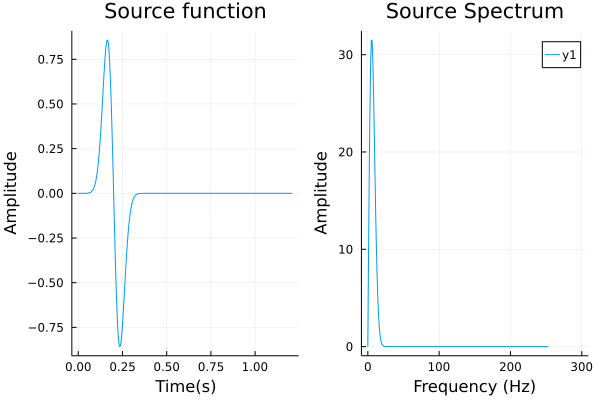

In [4]:
# Plot source fn
isrc= convert(Int64, nx/2);
# source location in grid in x-direction
f0   = 5 # dominant frequency of the source (Hz)
t0   = 1. / f0 # source time shift (This is equal to one period)
src= source_fn(f0, t0, "Gaussian");
println(size(src), size(time));
p_src= Plots.plot(time, src, title= "Source function", legend= false)
Plots.xlabel!(p_src, "Time(s)")
Plots.ylabel!(p_src, "Amplitude")


spec= abs.(FFTW.fft(src));
freqs= abs.(FFTW.fftfreq(length(time), nt));
p_spec= Plots.plot(freqs, spec, xlims= [0,300], title= "Source Spectrum") #, legend= false);
Plots.xlabel!(p_spec, "Frequency (Hz)")
Plots.ylabel!(p_spec, "Amplitude")

Plots.plot(p_src, p_spec, layout= (1,2))


In [17]:
p    = zeros(nx);
ir= isrc+ 500; # Receiver location
receiver= zeros(nt);

pt= Plots.scatter([isrc], [0], label= "Source");
Plots.scatter!(pt, [ir], [0], label= "Receiver");
#Plots.plot!(pt, x, p, label= \"Wave\");
#display(pt);

nx= length(p);
pold= zeros(nx);
pnew= zeros(nx);

anim= Plots.Animation()
d2px = zeros(nx);

  782.300 μs (2611 allocations: 179.30 KiB)


In [11]:
ProgressMeter.@showprogress for it in 1:nt-1
    for i in 2: nx-3
        d2px[i] = (p[i + 1] .- 2 .* p[i] .+ p[i - 1]) ./ (dx .^ 2);
    end

        pnew = 2 .* p .- pold .+ (c .^ 2) .* (dt .^ 2) .* d2px;
    pnew[isrc] = pnew[isrc] .+ src[it] ./ (dx) .* dt .^ 2;
    pold, p = p, pnew;

    receiver[it]= p[ir];

    # Snapshot
    idisp = 5 # display frequency
    if (it % idisp) == 0
        Plots.plot(pt, x, p, label= "Wave", xlims= (x[1], x[end]), ylim= ([0.0, 0.00007]))
        Plots.frame(anim)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40mm9mm


Plots.AnimatedGif("C:/Users/hp/Desktop/wave_propagation/fd/tmp.gif")
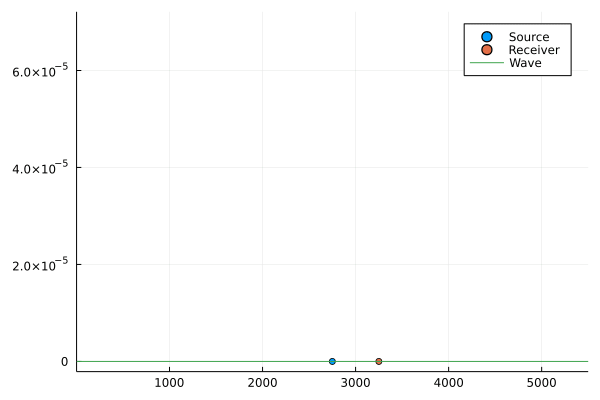

In [12]:
Plots.AnimatedGif("C:/Users/hp/Desktop/wave_propagation/fd/tmp.gif")